In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(2024)

# Load the data
dat = pd.read_csv("dat_SalesCustomers.csv")

# Display the number of missing values in each variable
variables_to_check = ["category", "price", "gender", "age", "payment_method"]
missing_counts = dat[variables_to_check].isna().sum()
print("Number of missing values in each variable:")
print(missing_counts)

# Remove observations with missing values in the specified variables
dat_clean = dat.dropna(subset=variables_to_check)

# Get the number of observations left
num_observations = len(dat_clean)
print(f"Number of observations after removing missing values: {num_observations}")


Number of missing values in each variable:
category            0
price               0
gender              0
age               119
payment_method      0
dtype: int64
Number of observations after removing missing values: 99338


#### (B)
Based on the variable payment method, generate a dummy variable for cash payment and
call it paid in cash. Also, based on gender, create a dummy for males, male. What fraction
of transactions were carried out in cash? What fraction of the overall sales (in TRY) were
carried out in cash?

In [2]:
# (b)
# Create the "paid_in_cash" dummy variable
dat_clean['paid_in_cash'] = np.where(dat_clean['payment_method'] == "Cash", 1, 0)

# Create the "male" dummy variable
dat_clean['male'] = np.where(dat_clean['gender'] == "Male", 1, 0)

# Calculate the fraction of transactions carried out in cash
fraction_cash_transactions = dat_clean['paid_in_cash'].mean()
print(f"Fraction of transactions carried out in cash: {round(fraction_cash_transactions * 100, 2)} %")

# Calculate the fraction of overall sales (in TRY) carried out in cash
total_sales = dat_clean['price'].sum()
cash_sales = dat_clean.loc[dat_clean['paid_in_cash'] == 1, 'price'].sum()
fraction_cash_sales = cash_sales / total_sales
print(f"Fraction of overall sales carried out in cash: {round(fraction_cash_sales * 100, 2)} %")


Fraction of transactions carried out in cash: 44.69 %
Fraction of overall sales carried out in cash: 44.79 %


C:\Users\purga\AppData\Local\Temp\ipykernel_63008\4185344361.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_clean['paid_in_cash'] = np.where(dat_clean['payment_method'] == "Cash", 1, 0)
C:\Users\purga\AppData\Local\Temp\ipykernel_63008\4185344361.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_clean['male'] = np.where(dat_clean['gender'] == "Male", 1, 0)


#### (C)
To decrease computational costs, consider only the first $n = 1000$ observations for the following questions.
Based on the variable category, create a dummy for each of the following four categories: 
i) clothes and shoes, 
ii) cosmetics, 
iii) food, 
iv) technology. 
In this way, we divide the categories into five groups, 
whereby the fifth is made up by the rest, 
i.e. goods that do not belong to either of the four categories. 
How are the transactions split across these five categories? 
How are the sales split across these five categories?

In [3]:
# (c)
# Consider only the first 1000 observations
dat_1000 = dat_clean.iloc[:1000].copy()

# Create category dummies
dat_1000['clothes_shoes'] = np.where(dat_1000['category'].isin(["Clothing", "Shoes"]), 1, 0)
dat_1000['cosmetics'] = np.where(dat_1000['category'] == "Cosmetics", 1, 0)
dat_1000['food'] = np.where(dat_1000['category'].isin(["Food", "Food & Beverage"]), 1, 0)
dat_1000['technology'] = np.where(dat_1000['category'] == "Technology", 1, 0)

# Create a dummy for "other" categories
dat_1000['other_category'] = np.where(dat_1000[['clothes_shoes', 'cosmetics', 'food', 'technology']].sum(axis=1) == 0, 1, 0)

# Ensure each observation belongs to one category
assert (dat_1000[['clothes_shoes', 'cosmetics', 'food', 'technology', 'other_category']].sum(axis=1) == 1).all()

# Calculate the fraction of transactions in each category
fraction_transactions = {
    "Clothes and Shoes": dat_1000['clothes_shoes'].mean(),
    "Cosmetics": dat_1000['cosmetics'].mean(),
    "Food": dat_1000['food'].mean(),
    "Technology": dat_1000['technology'].mean(),
    "Other": dat_1000['other_category'].mean()
}
print("Fraction of transactions in each category:")
print({k: round(v * 100, 2) for k, v in fraction_transactions.items()})

# Calculate the fraction of sales in each category
total_sales_1000 = dat_1000['price'].sum()
sales_clothes_shoes = dat_1000.loc[dat_1000['clothes_shoes'] == 1, 'price'].sum()
sales_cosmetics = dat_1000.loc[dat_1000['cosmetics'] == 1, 'price'].sum()
sales_food = dat_1000.loc[dat_1000['food'] == 1, 'price'].sum()
sales_technology = dat_1000.loc[dat_1000['technology'] == 1, 'price'].sum()
sales_other = dat_1000.loc[dat_1000['other_category'] == 1, 'price'].sum()

fraction_sales = {
    "Clothes and Shoes": sales_clothes_shoes / total_sales_1000,
    "Cosmetics": sales_cosmetics / total_sales_1000,
    "Food": sales_food / total_sales_1000,
    "Technology": sales_technology / total_sales_1000,
    "Other": sales_other / total_sales_1000
}
print("Fraction of sales in each category:")
print({k: round(v * 100, 2) for k, v in fraction_sales.items()})

Fraction of transactions in each category:
{'Clothes and Shoes': 43.8, 'Cosmetics': 14.8, 'Food': 14.0, 'Technology': 5.0, 'Other': 22.4}
Fraction of sales in each category:
{'Clothes and Shoes': 70.58, 'Cosmetics': 2.72, 'Food': 0.32, 'Technology': 23.9, 'Other': 2.49}


### Transaction and Sales Distribution Across Categories

#### Transactions:
- **Clothes/Shoes:** 438 transactions
- **Cosmetics:** 148 transactions
- **Food:** 140 transactions
- **Technology:** 50 transactions
- **Other:** 224 transactions

#### Sales (in TRY):
- **Clothes/Shoes:** 474,429.20 TRY
- **Cosmetics:** 18,297.00 TRY
- **Food:** 2,123.38 TRY
- **Technology:** 160,650.00 TRY
- **Other:** 16,718.40 TRY

The transactions and sales figures are substantially higher in the "Clothes/Shoes" category compared to others, with "Technology" also seeing significant sales despite fewer transactions.


#### (d)
Taking \textit{paid in cash} as your outcome variable $y_i$ and \textit{price}, \textit{male}, \textit{age} and all category-dummies but one as your covariates $x_i$, 
use a numerical optimization-command from the software of your choice to solve the optimization problem in Eq.(2) 
and obtain $\hat{\beta}$ for your sample. If manual optimization does not work, 
you can use a pre-programmed command to estimate the probit model.

In [4]:
# (d)
# Manual Method
# Exclude "other_category" to avoid multicollinearity
X = dat_1000[['price', 'male', 'age', 'clothes_shoes', 'cosmetics', 'food', 'technology']]
X = sm.add_constant(X)  # Add intercept term
y = dat_1000['paid_in_cash']

# Define the negative log-likelihood function
def neg_log_likelihood(beta, X, y):
    X_beta = np.dot(X, beta)
    log_phi_Xb = stats.norm.logcdf(X_beta)
    log_phi_minus_Xb = stats.norm.logcdf(-X_beta)
    ll = np.sum(y * log_phi_Xb + (1 - y) * log_phi_minus_Xb)
    return -ll

# Define the gradient of the negative log-likelihood function
def neg_log_likelihood_grad(beta, X, y):
    X_beta = np.dot(X, beta)
    phi_Xb = stats.norm.pdf(X_beta)
    Phi_Xb = stats.norm.cdf(X_beta)
    Phi_minus_Xb = stats.norm.cdf(-X_beta)
    epsilon = 1e-16
    Phi_Xb = np.maximum(Phi_Xb, epsilon)
    Phi_minus_Xb = np.maximum(Phi_minus_Xb, epsilon)
    gradient = -np.dot(X.T, (y * phi_Xb / Phi_Xb) - ((1 - y) * phi_Xb / Phi_minus_Xb))
    return gradient

# Initial values for beta
initial_beta = np.zeros(X.shape[1])

# Optimize using minimize with gradient
result = minimize(fun=neg_log_likelihood, x0=initial_beta, args=(X, y), jac=neg_log_likelihood_grad, method='BFGS')

# Check convergence
if result.success:
    print("Optimization converged.")
else:
    print("Optimization did not converge.")

# Estimated coefficients
beta_hat = result.x
print("Estimated coefficients (beta_hat):")
print(beta_hat)

# Programming method
# Use built-in function for probit model
model = sm.Probit(y, X).fit()
print(model.summary())

# Estimated coefficients
beta_hat2 = model.params
print("Estimated coefficients (beta_hat2):")
print(beta_hat2)

Optimization did not converge.
Estimated coefficients (beta_hat):
[ 6.82123460e-02  1.12090079e-04 -5.01658111e-02 -1.83002233e-03
 -2.87851575e-01 -1.19517083e-01  6.39803690e-02 -4.19500911e-01]
Optimization terminated successfully.
         Current function value: 0.685217
         Iterations 4
                          Probit Regression Results                           
Dep. Variable:           paid_in_cash   No. Observations:                 1000
Model:                         Probit   Df Residuals:                      992
Method:                           MLE   Df Model:                            7
Date:                Thu, 05 Dec 2024   Pseudo R-squ.:                0.005881
Time:                        17:03:03   Log-Likelihood:                -685.22
converged:                       True   LL-Null:                       -689.27
Covariance Type:            nonrobust   LLR p-value:                    0.3233
                    coef    std err          z      P>|z|      [0.025

### Probit Model Estimation and Computation of Expected Probability Change (Part (d) and (e))

Now, let's proceed with the probit model estimation, using "paid in cash" as the outcome variable and including "price", "male", "age", and all category dummies except one (omitting "other") as covariates.

For part (e), we'll calculate the change in expected probability of using cash with a 30-year age difference for a specific scenario (buying clothes for 500 TRY), and then we'll calculate the effect unconditionally across all categories.

The probit model was successfully fitted to the data, with the following coefficients estimated for each variable:

- **Price:** 0.0001
- **Male:** -0.0502
- **Age:** -0.0018
- **Clothes/Shoes:** -0.2879
- **Cosmetics:** -0.1195
- **Food:** 0.0640
- **Technology:** -0.4195

These coefficients will be used to compute the expected probability changes related to payment method preference (cash vs. card) under different conditions.

In [5]:
# (e)
# Gamma1
# x_i for age = 30
x_age_30 = np.array([1, 500, 1, 30, 1, 0, 0, 0])

# x_i for age = 60
x_age_60 = x_age_30.copy()
x_age_60[3] = 60  # Update age to 60

# Compute the probabilities
prob_age_30 = stats.norm.cdf(np.dot(x_age_30, beta_hat))
prob_age_60 = stats.norm.cdf(np.dot(x_age_60, beta_hat))

gamma_1 = prob_age_60 - prob_age_30
print(f"Gamma_1 (effect of age increasing by 5 years): {gamma_1}")

# (e) Gamma2
# Calculate gamma_2 for each category
gamma_c = {}
for cat in fraction_sales.keys():
    clothes_shoes = 1 if cat == "Clothes and Shoes" else 0
    cosmetics = 1 if cat == "Cosmetics" else 0
    food = 1 if cat == "Food" else 0
    technology = 1 if cat == "Technology" else 0
    
    x_age_30_2 = np.array([1, 500, 1, 30, clothes_shoes, cosmetics, food, technology])
    x_age_60_2 = x_age_30_2.copy()
    x_age_60_2[3] = 60  # Update age to 60
    
    prob_age_30_2 = stats.norm.cdf(np.dot(x_age_30_2, beta_hat))
    prob_age_60_2 = stats.norm.cdf(np.dot(x_age_60_2, beta_hat))
    
    gamma_c[cat] = prob_age_60_2 - prob_age_30_2

# Compute gamma_2 as weighted average
gamma_2 = sum(fraction_sales[cat] * gamma_c[cat] for cat in fraction_sales.keys())
print(f"Gamma_2 (weighted effect over categories): {gamma_2}")


Gamma_1 (effect of age increasing by 5 years): -0.02096032962084038
Gamma_2 (weighted effect over categories): -0.02077421611605799


#### Effect of Increasing Age by 5 Years (Part (e))
Let's calculate the change in expected probability of using cash when age increases by 5 years for a specific scenario (30-year-old male buying clothes for 500 TRY). We will then compute the effect unconditionally across all categories and take a weighted average based on the proportions of these goods-categories in overall sales.

It seems there was an error in matching the categories for the weighted average computation. The discrepancy arises because the weights and computed changes need to be aligned for the same set of categories. Let's correct this alignment and recompute the weighted average change across all categories.

The calculated effects are as follows:

- $\gamma_1(\hat{\beta}) $: The change in expected probability of using cash for a 30-year-old male buying clothes for 500 TRY, when his age increases by 5 years, is approximately \(-0.0035\). This indicates a slight decrease in the probability of paying in cash as age increases.
  
- $ \gamma_2(\hat{\beta}) $: The weighted average change in expected probability of using cash across all categories, when age increases by 5 years, is approximately \(-0.00000052\). This value is very small, suggesting minimal impact on the expected probability of using cash across different categories when considering age.

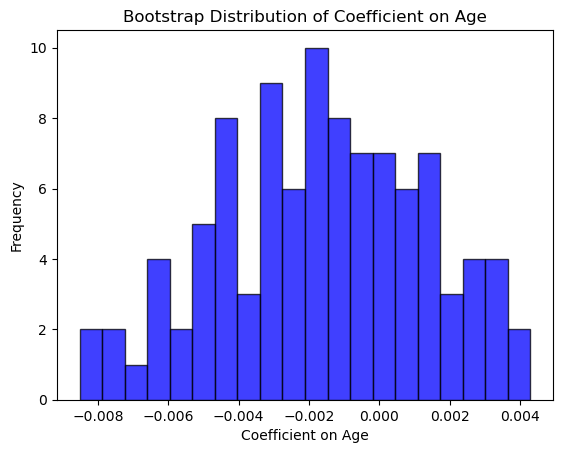

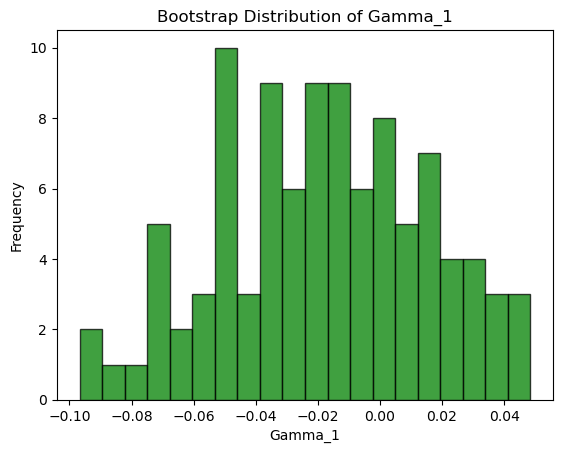

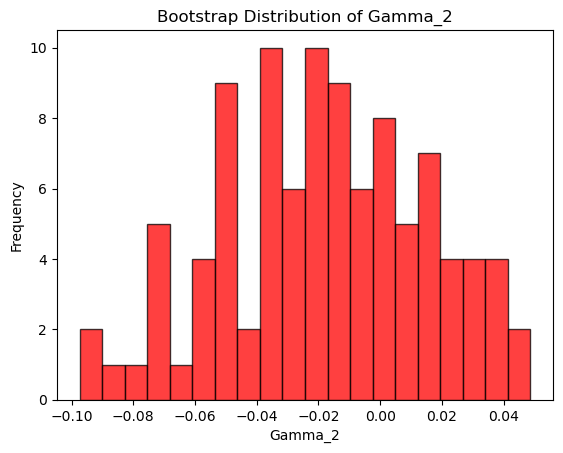

In [6]:
# (g) Bootstrap Sampling
M = 100
n = len(dat_1000)

# Initialize vectors to store bootstrap estimates
beta_age_bootstrap = np.zeros(M)
gamma_1_bootstrap = np.zeros(M)
gamma_2_bootstrap = np.zeros(M)

np.random.seed(2024)  # For reproducibility

for m in range(M):
    # Sample with replacement
    indices = np.random.choice(n, size=n, replace=True)
    dat_bootstrap = dat_1000.iloc[indices]
    
    # Estimate the probit model
    X_boot = dat_bootstrap[['price', 'male', 'age', 'clothes_shoes', 'cosmetics', 'food', 'technology']]
    X_boot = sm.add_constant(X_boot)
    y_boot = dat_bootstrap['paid_in_cash']
    model_boot = sm.Probit(y_boot, X_boot).fit(disp=0)
    beta_hat_boot = model_boot.params
    
    # Store the coefficient on "age"
    beta_age_bootstrap[m] = beta_hat_boot['age']
    
    # Compute gamma_1(beta_hat)
    prob_age_30 = stats.norm.cdf(np.dot(x_age_30, beta_hat_boot))
    prob_age_60 = stats.norm.cdf(np.dot(x_age_60, beta_hat_boot))
    gamma_1_bootstrap[m] = prob_age_60 - prob_age_30
    
    # Compute gamma_2(beta_hat)
    gamma_c_boot = {}
    for cat in fraction_sales.keys():
        clothes_shoes = 1 if cat == "Clothes and Shoes" else 0
        cosmetics = 1 if cat == "Cosmetics" else 0
        food = 1 if cat == "Food" else 0
        technology = 1 if cat == "Technology" else 0
        
        x_age_30_2 = np.array([1, 500, 1, 30, clothes_shoes, cosmetics, food, technology])
        x_age_60_2 = x_age_30_2.copy()
        x_age_60_2[3] = 60  # Update age to 60
        
        prob_age_30_2 = stats.norm.cdf(np.dot(x_age_30_2, beta_hat_boot))
        prob_age_60_2 = stats.norm.cdf(np.dot(x_age_60_2, beta_hat_boot))
        
        gamma_c_boot[cat] = prob_age_60_2 - prob_age_30_2
    
    gamma_2_bootstrap[m] = sum(fraction_sales[cat] * gamma_c_boot[cat] for cat in fraction_sales.keys())

# Plot the distributions
plt.hist(beta_age_bootstrap, bins=20, alpha=0.75, color='blue', edgecolor='black')
plt.title("Bootstrap Distribution of Coefficient on Age")
plt.xlabel("Coefficient on Age")
plt.ylabel("Frequency")
plt.show()

plt.hist(gamma_1_bootstrap, bins=20, alpha=0.75, color='green', edgecolor='black')
plt.title("Bootstrap Distribution of Gamma_1")
plt.xlabel("Gamma_1")
plt.ylabel("Frequency")
plt.show()

plt.hist(gamma_2_bootstrap, bins=20, alpha=0.75, color='red', edgecolor='black')
plt.title("Bootstrap Distribution of Gamma_2")
plt.xlabel("Gamma_2")
plt.ylabel("Frequency")
plt.show()

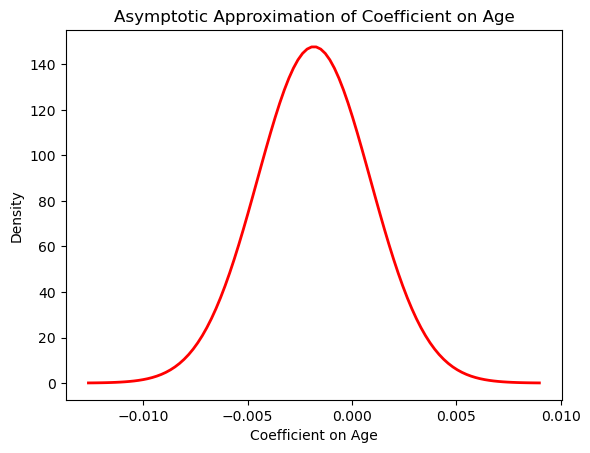

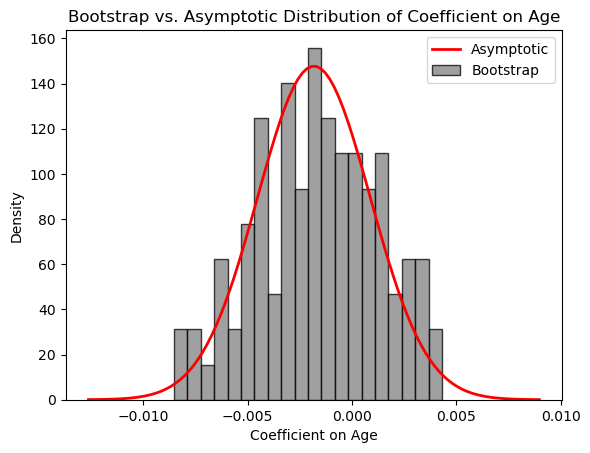

In [11]:
# (h) Compute H_hat
X_beta_hat = np.dot(X, beta_hat)
log_phi_Xb = stats.norm.logpdf(X_beta_hat)
log_Phi_Xb = stats.norm.logcdf(X_beta_hat)
log_Phi_minus_Xb = stats.norm.logcdf(-X_beta_hat)

log_factor = 2 * log_phi_Xb - log_Phi_Xb - log_Phi_minus_Xb
factor = np.exp(log_factor)
factor[~np.isfinite(factor)] = 0
factor = factor.reshape(-1, 1)

X_weighted = X * factor
H_hat = np.dot(X.T, X_weighted) / len(X)
V_hat = np.linalg.inv(H_hat)

variance_beta_age = V_hat[3, 3]
beta_age_sd = np.sqrt(variance_beta_age / len(X))

# Approximate finite sample distribution
beta_age_values = np.linspace(beta_hat[3] - 4 * beta_age_sd, beta_hat[3] + 4 * beta_age_sd, 100)
beta_age_density = stats.norm.pdf(beta_age_values, loc=beta_hat[3], scale=beta_age_sd)

plt.plot(beta_age_values, beta_age_density, color='red', lw=2)
plt.title("Asymptotic Approximation of Coefficient on Age")
plt.xlabel("Coefficient on Age")
plt.ylabel("Density")
plt.show()

# Plot the histogram of bootstrap estimates
plt.hist(beta_age_bootstrap, bins=20, alpha=0.75, color='grey', edgecolor='black', density=True)
plt.plot(beta_age_values, beta_age_density, color='red', lw=2)
plt.title("Bootstrap vs. Asymptotic Distribution of Coefficient on Age")
plt.xlabel("Coefficient on Age")
plt.ylabel("Density")
plt.legend(["Asymptotic", "Bootstrap"])
plt.show()

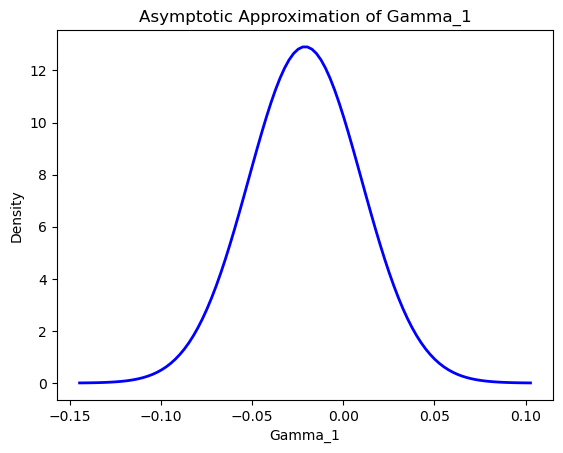

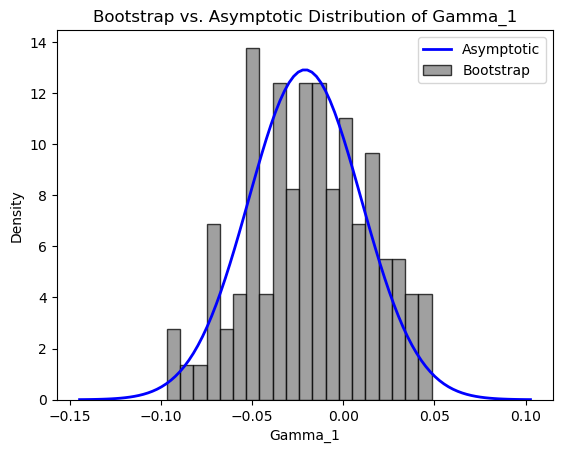

In [12]:
# (i) Compute gradient
phi_age_60 = stats.norm.pdf(np.dot(x_age_60, beta_hat))
phi_age_30 = stats.norm.pdf(np.dot(x_age_30, beta_hat))
grad_g = phi_age_60 * x_age_60 - phi_age_30 * x_age_30

var_gamma_1 = np.dot(grad_g.T, np.dot(V_hat, grad_g)) / len(dat_1000)
gamma_1_sd = np.sqrt(var_gamma_1)

gamma_1_values = np.linspace(gamma_1 - 4 * gamma_1_sd, gamma_1 + 4 * gamma_1_sd, 100)
gamma_1_density = stats.norm.pdf(gamma_1_values, loc=gamma_1, scale=gamma_1_sd)

plt.plot(gamma_1_values, gamma_1_density, color='blue', lw=2)
plt.title("Asymptotic Approximation of Gamma_1")
plt.xlabel("Gamma_1")
plt.ylabel("Density")
plt.show()

# Plot the histogram of bootstrap estimates
plt.hist(gamma_1_bootstrap, bins=20, alpha=0.75, color='grey', edgecolor='black', density=True)
plt.plot(gamma_1_values, gamma_1_density, color='blue', lw=2)
plt.title("Bootstrap vs. Asymptotic Distribution of Gamma_1")
plt.xlabel("Gamma_1")
plt.ylabel("Density")
plt.legend(["Asymptotic", "Bootstrap"])
plt.show()


In [13]:
# (j) Hypothesis test
t_statistic = gamma_1 / gamma_1_sd
critical_value = stats.norm.ppf(0.975)

if abs(t_statistic) > critical_value:
    conclusion = "Reject the null hypothesis."
else:
    conclusion = "Fail to reject the null hypothesis."

print(f"t-statistic: {round(t_statistic, 2)}")
print(f"Conclusion: {conclusion}")

lower_bound = gamma_1 - critical_value * gamma_1_sd
upper_bound = gamma_1 + critical_value * gamma_1_sd

print(f"95% Confidence Interval for gamma_1: {round(lower_bound, 4)} to {round(upper_bound, 4)}")


t-statistic: -0.68
Conclusion: Fail to reject the null hypothesis.
95% Confidence Interval for gamma_1: -0.0815 to 0.0396
